<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Job_search_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit, prange
from quantecon.distributions import BetaBinomial
from scipy.special import binom, beta
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

## Exercise 1

In [3]:
class CareerWorkerProblem:

    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=1,
                 F_b=1,
                 G_a=1,
                 G_b=1):

        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # Set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # Set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

In [4]:
def operator_factory(cw, parallel_flag=True):

    """
    Returns jitted versions of the Bellman operator and the
    greedy policy function

    cw is an instance of ``CareerWorkerProblem``
    """

    θ, ϵ, β = cw.θ, cw.ϵ, cw.β
    F_probs, G_probs = cw.F_probs, cw.G_probs
    F_mean, G_mean = cw.F_mean, cw.G_mean

    @njit(parallel=parallel_flag)
    def T(v):
        "The Bellman operator"

        v_new = np.empty_like(v)

        for i in prange(len(v)):
            for j in prange(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]                    # Stay put
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs        # New job
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs  # New life
                v_new[i, j] = max(v1, v2, v3)

        return v_new

    @njit
    def get_greedy(v):
        "Computes the v-greedy policy"

        σ = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs
                if v1 > max(v2, v3):
                    action = 1
                elif v2 > max(v1, v3):
                    action = 2
                else:
                    action = 3
                σ[i, j] = action

        return σ

    return T, get_greedy

In [5]:
def solve_model(cw,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(cw, parallel_flag=use_parallel)

    # Set up loop
    v = np.ones((cw.grid_size, cw.grid_size)) * 100  # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [6]:
cw = CareerWorkerProblem()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

In [7]:
n_sims = 20
F_cdf = cw.F_probs.cumsum()
G_cdf = cw.G_probs.cumsum()
thetas, epsilons = cw.θ, cw.ε
theta_indices = np.full(n_sims, -1, dtype=int)
epsilon_indices = np.full(n_sims, -1, dtype=int)

In [8]:
theta_indices[0] = 0
epsilon_indices[0] = 0
for i in range(n_sims-1):
  t_idx, e_idx = theta_indices[i], epsilon_indices[i]
  action = greedy_star[t_idx, e_idx]
  if action == 1:
    theta_indices[i+1] = theta_indices[i]
    epsilon_indices[i+1] = epsilon_indices[i]
  elif action == 2:
    theta_indices[i+1] = theta_indices[i]
    epsilon_indices[i+1] = qe.random.draw(G_cdf)
  else:
    theta_indices[i+1] = qe.random.draw(F_cdf)
    epsilon_indices[i+1] = qe.random.draw(G_cdf)
theta_draws = thetas[theta_indices]
epsilon_draws = epsilons[epsilon_indices]

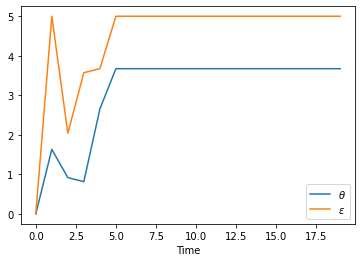

In [9]:
for draws, label in zip([theta_draws, epsilon_draws], [r'$\theta$', r'$\epsilon$']):
  plt.plot(draws, label=label)
plt.xlabel('Time')
plt.legend();

## Exercise 2

In [10]:
G_cdf, F_cdf = cw.G_probs.cumsum(), cw.F_probs.cumsum()

@njit
def Simulations(policy=greedy_star, theta_init=0, epsilon_init=0, n_sims=25000):  
  t_idx_init = 0
  e_idx_init = 0
  storage = np.empty(n_sims)
  for i in prange(n_sims):
    action = policy[t_idx_init, e_idx_init]
    t_idx_new = t_idx_init
    count = 0
    while action != 1:
      if action == 2:
        t_idx_next = t_idx_new
        e_idx_next = qe.random.draw(G_cdf)
      else:
        t_idx_next = qe.random.draw(F_cdf)
        e_idx_next = qe.random.draw(G_cdf)  
      action = policy[t_idx_next, e_idx_next]
      t_idx_new = t_idx_next
      count += 1
    storage[i] = count
  return storage

In [11]:
np.median(Simulations())

7.0